In [1]:
import os
import shutil
import datetime
import numpy as np 
import pandas as pd 

In [3]:
logs_dir = './logs/'
if os.path.exists(logs_dir):
    shutil.rmtree(logs_dir)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/Anjil/Documents/ProductClassification/All-Data/data_4_classes/train'
test_dir = 'C:/Users/Anjil/Documents/ProductClassification/All-Data/data_4_classes/test'
train_csv = 'C:/Users/Anjil/Documents/ProductClassification/All-Data/data_4_classes/training_set.csv'
test_csv = 'C:/Users/Anjil/Documents/ProductClassification/All-Data/data_4_classes/testing_set.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=4,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,                                         # changed from 32
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,                                          # changed from 32
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,                                           # changed from 32
    class_mode=None,
    shuffle=False
)

Found 860 validated image filenames belonging to 8 classes.
Found 215 validated image filenames belonging to 8 classes.
Found 86 validated image filenames.


In [5]:
class_labels = list(train_generator.class_indices.keys())
print('class_labels:',class_labels)

class_labels: ['MBE', 'MDR-GR', 'MLN-YL', 'MNR-TQ', 'MOP-YL', 'MTR', 'NAP-RD', 'person']


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
history = model.fit( 
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, reduce_lr],
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/10
26/26 [==============================] - 35s 1s/step - loss: 1.9986 - accuracy: 0.4758 - val_loss: 0.8697 - val_accuracy: 0.9948 - lr: 1.0000e-04
Epoch 2/10
26/26 [==============================] - 30s 1s/step - loss: 0.9953 - accuracy: 0.8659 - val_loss: 0.5348 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/10
26/26 [==============================] - 29s 1s/step - loss: 0.6569 - accuracy: 0.9783 - val_loss: 0.4685 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/10
26/26 [==============================] - 29s 1s/step - loss: 0.5539 - accuracy: 0.9915 - val_loss: 0.4472 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/10
26/26 [==============================] - 29s 1s/step - loss: 0.5055 - accuracy: 0.9964 - val_loss: 0.4363 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
26/26 [==============================] - 29s 1s/step - loss: 0.4843 - accuracy: 0.9952 - val_loss: 0.4298 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/10
26/26 [==============================] - 29s 1s

In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

7/7 [==============================] - 5s 721ms/step - loss: 0.4174 - accuracy: 1.0000
Validation accuracy: 100.00%


In [11]:
for layer in base_model.layers[-60:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback],
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/20
26/26 [==============================] - 31s 1s/step - loss: 0.6215 - accuracy: 0.9650 - val_loss: 0.4157 - val_accuracy: 1.0000
Epoch 2/20
26/26 [==============================] - 28s 1s/step - loss: 0.5209 - accuracy: 0.9880 - val_loss: 0.4150 - val_accuracy: 1.0000
Epoch 3/20
26/26 [==============================] - 27s 1s/step - loss: 0.4633 - accuracy: 0.9976 - val_loss: 0.4146 - val_accuracy: 1.0000
Epoch 4/20
26/26 [==============================] - 28s 1s/step - loss: 0.4515 - accuracy: 0.9976 - val_loss: 0.4143 - val_accuracy: 1.0000
Epoch 5/20
26/26 [==============================] - 27s 1s/step - loss: 0.4375 - accuracy: 1.0000 - val_loss: 0.4138 - val_accuracy: 1.0000
Epoch 6/20
26/26 [==============================] - 27s 1s/step - loss: 0.4365 - accuracy: 0.9988 - val_loss: 0.4134 - val_accuracy: 1.0000
Epoch 7/20
26/26 [==============================] - 28s 1s/step - loss: 0.4252 - accuracy: 1.0000 - val_loss: 0.4131 - val_accuracy: 1.0000
Epoch 8/20
26/26 [==

In [ ]:
%tensorboard --logdir logs/fit

In [12]:
model.save('allround.h5')

In [13]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

7/7 [==============================] - 5s 717ms/step - loss: 0.4066 - accuracy: 1.0000
Validation accuracy: 100.00%


class_labels: ['MBE', 'MDR-GR', 'MLN-YL', 'MNR-TQ', 'MOP-YL', 'MTR', 'NAP-RD', 'person']
1/1 [==============================] - 0s 392ms/step
predictions: [[1.9823365e-05 7.0522845e-05 1.7112425e-05 9.9845457e-01 2.0114570e-04
  4.6006564e-05 1.1601765e-03 3.0642685e-05]]


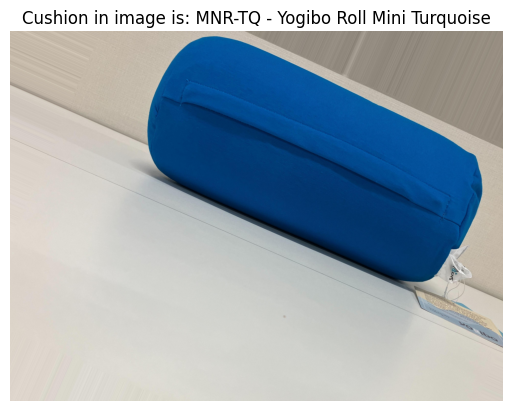

Cushion in image is: MNR-TQ - Yogibo Roll Mini Turquoise


In [15]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

csv_file = 'C:/Users/Anjil/Documents/ProductClassification/All-Data/yogibo_product.csv'
product_df = pd.read_csv(csv_file, on_bad_lines='skip')

relevant_classes = ['MNR-TQ', 'MOP-YL', 'NAP-RD'] 
filtered_df = product_df[product_df['pdt_pro_cd'].isin(relevant_classes)]

class_to_product = dict(zip(filtered_df['pdt_pro_cd'], filtered_df['pdt_nm_us']))

model = load_model('allround.h5')


img = 'C:/Users/Anjil/Documents/ProductClassification/cushion_data/train/trainingMNRTQ_0_4717.jpg'
frame = cv2.imread(img)
frame_resized = cv2.resize(frame, (224, 224))
frame_resized = img_to_array(frame_resized) / 255.0
frame_resized = np.expand_dims(frame_resized, axis=0)

class_labels = list(train_generator.class_indices.keys())
print('class_labels:',class_labels)

predictions = model.predict(frame_resized)
print('predictions:',predictions)
predicted_class_idx = np.argmax(predictions)
predicted_class = class_labels[predicted_class_idx]
product_name = class_to_product.get(predicted_class, "Unknown Product")

plt.imshow(frame[..., ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.title(f'Cushion in image is: {predicted_class} - {product_name}')
plt.show()

print(f'Cushion in image is: {predicted_class} - {product_name}')